In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import spacy
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

In [3]:
# RQ3: How stable is the community working on the topics (new authors emerging, authors staying on for the whole time,
# or authors “leaving” the area)?

In [4]:
data = pd.read_csv('./data/data.csv')

In [5]:
data.keys()

Index(['Unnamed: 0', 'Document Title', 'Authors', 'Author Affiliations',
       'Publication Title', 'Date Added To Xplore', 'Publication Year',
       'Volume', 'Issue', 'Start Page', 'End Page', 'Abstract', 'ISSN',
       'ISBNs', 'DOI', 'Funding Information', 'PDF Link', 'Author Keywords',
       'IEEE Terms', 'INSPEC Controlled Terms', 'INSPEC Non-Controlled Terms',
       'Mesh_Terms', 'Article Citation Count', 'Patent Citation Count',
       'Reference Count', 'License', 'Online Date', 'Issue Date',
       'Meeting Date', 'Publisher', 'Document Identifier'],
      dtype='object')

In [6]:
year = data['Publication Year']
data = data['Authors'].str.split(';', expand=True)
data = data.fillna(value=-1)
data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,T. Dingsøyr,F. O. Bjørnson,F. Shull,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,G. Li,H. Dong,Q. Zheng,M. Zhou,Y. Guo,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,M. Ardis,P. Bourque,T. Hilburn,K. Lasfer,S. Lucero,J. McDonald,A. Pyster,M. Shaw,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,O. Hazzan,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,P. Johnson,M. Ekstedt,I. Jacobson,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3588,A. B. Bener,M. Morisio,A. Miranskyy,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3589,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3590,G. Robles,I. Steinmacher,P. Adams,C. Treude,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [7]:
def GetAuthorsandYear(data):
    b = None
    for column in data:
        r = data[column].to_frame().join(year)
        r.rename(columns={ r.columns[0]: "Author" }, inplace = True)
        if b is None:
            b = r
        else:
            b = pd.concat([b, r])
    b.reset_index(drop = True)
    b = b[b.Author != -1]
    b['Count'] = 1
    b = b.rename({ 'Publication Year': 'Year'}, axis=1)
    result = b.pivot_table(index='Author', 
                        columns='Year', 
                        values='Count',
                        aggfunc=np.sum,
                        fill_value = 0)
    return result

In [8]:
res = GetAuthorsandYear(data)
res['summe'] = res.sum(axis=1)
res.sort_values(by=["summe"], ascending=False)

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe
Author,,,,,,,,,,,,,,
A. E. Hassan,1,0,0,0,2,2,3,6,4,2,8,12,7,47
Y. Liu,15,0,1,0,0,1,2,2,0,2,4,4,3,34
D. Spinellis,2,2,0,0,1,4,6,5,6,6,1,0,0,33
Y. Li,27,0,0,0,0,1,0,1,0,0,1,1,1,32
Y. Zhang,19,0,0,0,0,0,0,1,2,0,5,2,2,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M. Munoz,0,0,0,0,0,0,0,0,0,1,0,0,0,1
M. Muller,1,0,0,0,0,0,0,0,0,0,0,0,0,1
M. Mukelabai,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [9]:
def SortbyYear(data,jahr,publications):    
     for item in data:   
            p = data.loc[data[jahr] >= publications]
            return p.sort_values(by=[jahr], ascending=False)

In [10]:
SortbyYear(res,2019,3)

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe
Author,,,,,,,,,,,,,,
D. Lo,0,0,0,0,0,0,0,1,1,1,11,10,5,29
X. Xia,0,0,0,0,0,0,0,0,0,0,10,11,3,24
A. E. Hassan,1,0,0,0,2,2,3,6,4,2,8,12,7,47
T. Menzies,0,0,1,2,2,0,1,0,0,5,6,7,4,28
I. Ozkaya,0,0,0,0,0,0,0,0,0,0,6,3,2,11
G. Fairbanks,0,0,0,0,0,1,0,0,0,0,6,1,0,8
L. Zhang,12,0,0,2,1,1,0,1,0,0,6,6,2,31
M. Harman,0,0,2,1,1,0,2,0,4,2,6,3,5,26
Y. Zhang,19,0,0,0,0,0,0,1,2,0,5,2,2,31


In [11]:
x = res
x = x.sort_values(by=['summe'], ascending=False).head(5)
x

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe
Author,,,,,,,,,,,,,,
A. E. Hassan,1,0,0,0,2,2,3,6,4,2,8,12,7,47
Y. Liu,15,0,1,0,0,1,2,2,0,2,4,4,3,34
D. Spinellis,2,2,0,0,1,4,6,5,6,6,1,0,0,33
Y. Li,27,0,0,0,0,1,0,1,0,0,1,1,1,32
Y. Zhang,19,0,0,0,0,0,0,1,2,0,5,2,2,31


<BarContainer object of 5 artists>

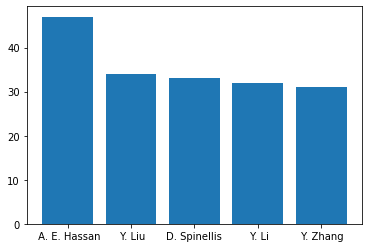

In [12]:
plt.bar(x.index,x['summe'])

In [13]:
def ShowBestOfYear(data,jahr):
    x = data
    x = x.sort_values(by=[jahr], ascending=False).head(5)
    plt.bar(x.index,x[jahr])
    

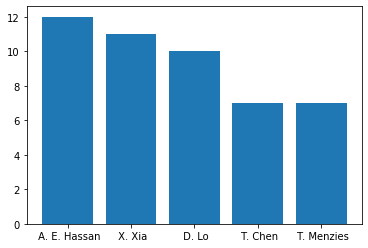

In [14]:
ShowBestOfYear(res,2020)

In [15]:
#new comer
result = res
result['summe_'] =  result[2018] + result[2019] + result[2020] + result[2021]
result = result[result.summe_ >= 4]
result = result[result.summe_ >= 0.7 * result.summe]
result = result.sort_values(by=['summe_'], ascending=False)
result

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe,summe_
Author,,,,,,,,,,,,,,,
D. Lo,0,0,0,0,0,0,0,1,1,1,11,10,5,29,27
X. Xia,0,0,0,0,0,0,0,0,0,0,10,11,3,24,24
T. Menzies,0,0,1,2,2,0,1,0,0,5,6,7,4,28,22
J. Grundy,0,0,1,0,1,0,0,0,1,2,0,6,6,17,14
I. Ozkaya,0,0,0,0,0,0,0,0,0,0,6,3,2,11,11
A. Serebrenik,0,0,0,0,0,0,0,0,2,3,3,2,2,12,10
T. Chen,0,0,0,0,0,0,0,1,0,0,1,7,2,11,10
X. Luo,3,0,0,0,0,0,0,0,0,1,1,2,5,12,9
Z. Xing,0,0,0,0,0,0,0,0,0,1,4,1,3,9,9


In [21]:
#staying
result = res
result['summe_'] =  result[2018] + result[2019] + result[2020] + result[2021]
result.sort_values(by=['summe_'], ascending=False)
result = result[result.summe_ >= 4]
result = result[result.summe_ <= 0.5 * result.summe]
result = result.sort_values(by=['summe_'], ascending=False)
result

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe,summe_
Author,,,,,,,,,,,,,,,
L. Zhang,12,0,0,2,1,1,0,1,0,0,6,6,2,31,14
Y. Liu,15,0,1,0,0,1,2,2,0,2,4,4,3,34,13
B. Adams,0,0,0,0,1,2,1,4,1,1,2,4,2,18,9
Y. Zhang,19,0,0,0,0,0,0,1,2,0,5,2,2,31,9
X. Wang,13,0,2,0,0,1,2,1,2,1,0,4,4,30,9
J. C. Carver,0,0,0,0,0,0,2,3,6,3,2,1,2,19,8
R. Oliveto,0,0,1,0,0,2,3,0,2,2,3,0,3,16,8
D. Spinellis,2,2,0,0,1,4,6,5,6,6,1,0,0,33,7
T. Gorschek,0,1,0,2,0,1,0,2,1,3,1,2,1,14,7


In [17]:
#leavingauthors
def LeavingAuthors(data,start):
    p = data
    for year in range(start,2022,1):
        p = p[p[year] == 0]
    return p

In [18]:
LeavingAuthors(res,2014)

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,summe,summe_
Author,,,,,,,,,,,,,,,
A. -F. Zhu,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A. Ahmad,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
A. Appari,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
A. Aurum,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A. Beaulieu,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z. Zheng,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Z. Zhi,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Z. Zhou,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
data = pd.read_csv('./data/data.csv',dtype={'Abstract': str}, usecols = ['Authors','Publication Year'])
data.head()
test = {}

words = Counter()
#data[data['Publication Year'] == year]
for year in range(2009,2021,1):
    for columns in data[data['Publication Year'] == year].itertuples():

        text = columns[1] #
        if type(text) is str:
            for topic in text.split(';'):
                words[topic] += 1

        test[year] = words

    words = Counter()

In [20]:
test[2018].most_common(80)

[('D. Spinellis', 6),
 (' T. Menzies', 5),
 ('M. Kersten', 4),
 (' C. Bird', 4),
 (' N. Medvidović', 4),
 ('G. J. Holzmann', 4),
 ('J. C. Carver', 3),
 (' T. Zimmermann', 3),
 (' A. Serebrenik', 3),
 (' T. Gorschek', 3),
 (' G. Antoniol', 2),
 ('G. Mathew', 2),
 (' M. Shaw', 2),
 (' R. Capilla', 2),
 (' A. Valdezate', 2),
 ('H. Erdogmus', 2),
 ('T. Menzies', 2),
 (' K. Wnuk', 2),
 ('C. Ebert', 2),
 (' J. Grundy', 2),
 (' M. Storey', 2),
 ('N. Black', 2),
 (' L. Tan', 2),
 ('R. Prikladnicki', 2),
 (' X. Franch', 2),
 ('Y. Wang', 2),
 ('M. Waterman', 2),
 (' C. Ebert', 2),
 (' D. Weyns', 2),
 (' N. A. Kraft', 2),
 (' C. McMillan', 2),
 (' A. E. Hassan', 2),
 (' F. Khomh', 2),
 (' M. Harman', 2),
 (' R. Gheyi', 2),
 (' M. Ribeiro', 2),
 (' O. Zimmermann', 2),
 (' T. Mikkonen', 2),
 ('S. Gregory', 2),
 ('J. Carver', 2),
 (' B. Penzenstadler', 2),
 (' C. Kästner', 2),
 ('L. Yu', 2),
 (' R. Oliveto', 2),
 (' A. De Lucia', 2),
 (' Z. Yang', 2),
 (' J. Sun', 2),
 (' Y. Liu', 2),
 ('V. Garousi'